## Scrap book for testing stuff

In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen

## Define tickers and date span

In [23]:
ticker1_name = 'RIO'
ticker2_name = 'RIO.L'

start_date = '2019-01-01'
end_date = '2021-01-01'

## Get data

In [24]:
ticker1 = yf.Ticker(ticker1_name)
ticker2 = yf.Ticker(ticker2_name)

data1 = ticker1.history(start=start_date, end=end_date, frequency='1dy')['Close'].rename(ticker1_name)
data2 = ticker2.history(start=start_date, end=end_date, frequency='1dy')['Close'].rename(ticker2_name)

df = pd.concat([np.log10(data1), np.log10(data2)], axis=1).bfill()

Text(0.5, 1.0, 'RIO.L')

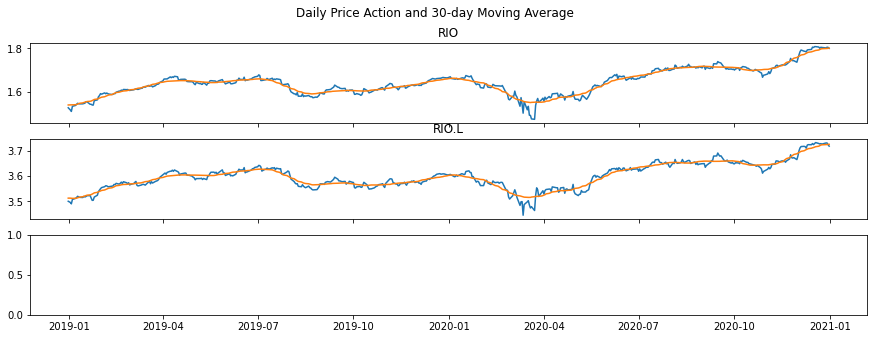

In [25]:
df_mean = pd.concat([df[ticker1_name].rolling(window=30, center=True, min_periods=0).mean(), 
                        df[ticker2_name].rolling(window=30, center=True, min_periods=0).mean()], 
                       axis=1)
df_spread = df[ticker2_name]-df[ticker1_name]

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(15, 5))
fig.suptitle('Daily Price Action and 30-day Moving Average')

ax1.plot(df[ticker1_name])
ax1.plot(df_mean[ticker1_name])
ax1.set_title(ticker1_name)

ax2.plot(df[ticker2_name])
ax2.plot(df_mean[ticker2_name])
ax2.set_title(ticker2_name)

## Correlation

In [26]:
corr = df.corr()
print('Daily Price:', corr[ticker1_name][ticker2_name])

Daily Price: 0.9790340897417239


## Johansen cointegration test

In [35]:
jres = coint_johansen(df, det_order=0, k_ar_diff=1)

In [36]:
print('trace_stat:\n', jres.trace_stat)
print('trace_stat_crit_vals:\n', jres.trace_stat_crit_vals)
print('max_eig_stat:\n', jres.max_eig_stat)
print('max_eig_stat_crit_vals:\n', jres.max_eig_stat_crit_vals)

trace_stat:
 [19.77500968  1.60159832]
trace_stat_crit_vals:
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]
max_eig_stat:
 [18.17341136  1.60159832]
max_eig_stat_crit_vals:
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]]


## Hacky stats stuff
Most of this is useless... just go down to spread stuff at the end of the section

In [29]:
# get ratio of series averages (average price of one relitive to the other)
norm_factor = df[ticker2_name].mean() / df[ticker1_name].mean()
# normalise prices for analysis and graphing purposes
df_norm = pd.concat([df[ticker1_name]*norm_factor, df[ticker2_name]], axis=1)

# target price of stock (average between two price points at any given t)
df_norm_mid = df_norm.mean(axis=1)

# N-day moving average of target price
N = 10
df_norm_mid_MA = df_norm_mid.rolling(window=N, center=True, min_periods=0).mean()

# N-day standard deviation of target price
std_mid = df_norm_mid.rolling(window=N, center=True, min_periods=0).std()

# M standard deviations of the mean target price
M = 1
df_norm_mid_MA_std = pd.concat([df_norm_mid_MA+(M*std_mid), df_norm_mid_MA-(M*std_mid)], axis=1)
# rename columns for plot
df_norm_mid_MA_std = df_norm_mid_MA_std.rename(columns={0: 'std upper', 1: 'std lower'})

# plot normalised prices
#ax = df_norm.plot(
#                    figsize=(15, 5), 
#                    color = ['orange', 'r'], 
#                    ylim=[df_norm.min().min(), df_norm.max().max()]
#                 )

# plot standard deviation interval from mean target price
#df_norm_mid_MA_std.plot(ax=ax, color = ['c', 'g'])

## Trading intervals

Calculate spread, mean spread, and trading intervals based on standard deviation from mean spread

In [33]:
df_spread = df_norm[ticker1_name] - df[ticker2_name]
spread_mean = df_spread.mean()
spread_std = df_spread.std()

n = 1
upper = spread_mean + (n * spread_std)
lower = spread_mean - (n * spread_std)

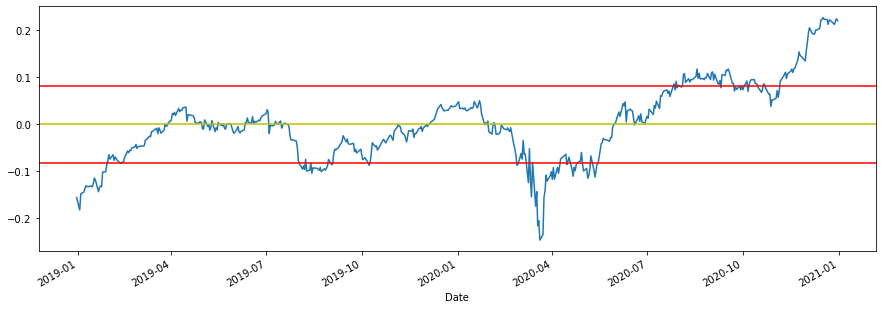

In [34]:
ax3 = df_spread.plot(figsize=(15, 5))

ax3.axhline(y=lower, color='r', linestyle='-')
ax3.axhline(y=upper, color='r', linestyle='-')
ax3.axhline(y=spread_mean, color='y', linestyle='-')

In [32]:
# divide 3 by two 